In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import glob
import os
import importlib
from raster_utils import file_utils, band_indices
import datetime as dt
import matplotlib.pyplot as plt

#importlib.reload(band_indices)
#importlib.reload(file_utils)

In [2]:
#Files
data_dir = '/Users/miksch/Thesis_Files/Raw_Data/Landsat/EL_fmask/'
out_dir = '/Users/miksch/Thesis_Files/Processed/Landsat/EL_LS8/'
ls8_sr_files = glob.glob(os.path.join(data_dir,'LS8','*.tif'))
ls8_dn_files = glob.glob(os.path.join(data_dir,'LS8_DN','*.tif'))
nlcd_file = os.path.join(data_dir,'NLCD','NLCD2011.tif')
ls8_dms_files = glob.glob()

ls8_sr_bands = pd.read_csv('band_list_ls8_sr.csv',index_col=[0])['Name']
nlcd_bands = pd.read_csv('band_list_nlcd_2011.csv',index_col=[0])['Name']

In [3]:
#Landsat 8
#Master xarray dataarray

ls8_sr = file_utils.append_rasterio(files=ls8_sr_files,band_lookup=ls8_sr_bands)
nlcd = xr.open_rasterio(nlcd_file)
nlcd = file_utils.band_to_var(nlcd,nlcd_bands)
ls8_dn = file_utils.append_rasterio(ls8_sr_files,rewrite_bands=False).sel(band=slice(2,7))

#Merge together NLCD
ls8_master = xr.merge([ls8_sr,nlcd,ls8_dn])
ls8_master.attrs = ls8_sr.attrs
ls8_master['qa_mask'] = ls8_master['pixel_qa'].isin([322, 386, 834, 898, 1346])
ls8_master.to_netcdf(os.path.join(out_dir,'ls8_nomasks.nc'))

In [ ]:
ls8_master = ls8_master.where(ls8_master['qa_mask'],np.nan)
ls8_master = ls8_master.where(ls8_master['impervious'] < 75,np.nan)

In [4]:
#Calculate BCI and NDBI
bci_list = []
for t in ls8_master['time']:
    temp_bci = band_indices.BCI(ls8_master['band_values'].sel(time=t).values)
    bci_list.append(temp_bci)
    
ls8_master['BCI'] = (('time','y','x'),np.array(bci_list))
ls8_master['NDBI'] = band_indices.NDBI(ls8_master['B6'],ls8_master['B5'])

ls8_master = ls8_master.drop(['band','band_values'])

/Users/miksch/git/triangle-method/tri_method_jupyter/raster_utils/band_indices.py:86: RuntimeWarning: All-NaN slice encountered
  HVL_maxes = np.nanmax(tcap,axis=(1,2))[:,np.newaxis,np.newaxis]
/Users/miksch/git/triangle-method/tri_method_jupyter/raster_utils/band_indices.py:87: RuntimeWarning: All-NaN slice encountered
  HVL_mins = np.nanmin(tcap,axis=(1,2))[:,np.newaxis,np.newaxis]


In [5]:
#Output to .nc files
for t in ls8_master['time'].values:
    print(t)
    time_str = pd.to_datetime(t).strftime('%Y%m%d')
    ls8_master.sel(time=t).to_netcdf(os.path.join(out_dir,'v01',f'ls8_{time_str}_v01.nc'))

ls8_master.to_netcdf(os.path.join(out_dir,f'ls8_v01.nc'))

2016-05-16T00:00:00.000000000
2016-06-01T00:00:00.000000000
2016-06-17T00:00:00.000000000
2016-07-03T00:00:00.000000000
2016-07-19T00:00:00.000000000
2016-08-04T00:00:00.000000000
2016-08-20T00:00:00.000000000
2016-09-05T00:00:00.000000000
2016-09-21T00:00:00.000000000
2016-10-07T00:00:00.000000000
2016-10-23T00:00:00.000000000
2017-05-03T00:00:00.000000000
2017-06-04T00:00:00.000000000
2017-06-20T00:00:00.000000000
2017-07-06T00:00:00.000000000
2017-07-22T00:00:00.000000000
2017-08-07T00:00:00.000000000
2017-08-23T00:00:00.000000000
2017-09-08T00:00:00.000000000
2017-10-10T00:00:00.000000000
2017-10-26T00:00:00.000000000
2018-05-06T00:00:00.000000000
2018-05-22T00:00:00.000000000
2018-06-07T00:00:00.000000000
2018-06-23T00:00:00.000000000
2018-07-09T00:00:00.000000000
2018-07-25T00:00:00.000000000
2018-08-10T00:00:00.000000000
2018-08-26T00:00:00.000000000
2018-09-11T00:00:00.000000000
2018-09-27T00:00:00.000000000
2018-10-13T00:00:00.000000000


In [ ]:
#NOTE: all cells from here on used to be triangle_method.ipynb

#Open dataset after pre-processing raster images
open_dir = '/Users/miksch/Thesis_Files/Processed/landsat/EL_LS8/'
ls8 = xr.open_dataset(os.path.join(open_dir,'ls8_v01.nc'),mask_and_scale=True)

#Create empty data variables for tstar and fr
ls8['tstar'] = xr.Variable(('time','y','x'),ls8['B10'].values)
ls8['FR'] = xr.Variable(('time','y','x'),ls8['NDVI'].values)
ls8['EF'] = xr.Variable(('time','y','x'),ls8['NDVI'].values)

In [ ]:
bands = ['B10','NDVI','EF','tstar','FR']

raster_bands = {}
raster_info = {}

for t in ls8['time'].values:
    
    tir = ls8['B10'].sel(time=t).values * .1
    ndvi = ls8['NDVI'].sel(time=t).values
    ef = ls8['EF'].sel(time=t).values
    tstar = ls8['tstar'].sel(time=t).values
    fr = ls8['NDVI'].sel(time=t).values

    raster_bands[str(t.astype(str))] = dict(zip(bands,[tir,ndvi,ef]))
    raster_info[str(t.astype(str))] = {'ndvio':0,'ndvis':0,'tir_max':0,'tir_min':0,
                      'we_points':np.array(([0,0],[0,0]))}
#
pickle.dump(raster_bands,open('raster_bands.p','wb'))    
pickle.dump(raster_info,open('raster_info.p','wb'))

In [ ]:
bands = pickle.load(open('raster_bands.p','rb'))
old_vals = pickle.load(open('/Users/miksch/Thesis_Files/Processed/landsat/LS_1617_fmask/raster_info.p','rb'))
new_bands = pickle.load(open('/Users/miksch/Thesis_Files/Processed/landsat/EL_LS8/raster_bands.p','rb'))

In [ ]:
out_bands = ['EF','tstar','FR']

for o in out_bands:
    temp_band = []
    for t in new_bands:
        temp_band.append(new_bands[t][o])
    band_array = np.array(temp_band)
    ls8[o] = (('time','y','x'),band_array)

In [13]:
ls8.to_netcdf('/Users/miksch/Thesis_Files/Processed/landsat/EL_LS8/ls8_v02.nc')

NameError: name 'ls8' is not defined

In [17]:
#https://stackoverflow.com/questions/10454316/how-to-project-and-resample-a-grid-to-match-another-grid-with-gdal-python
from osgeo import gdal, gdalconst

# Source
src_filename = '/Users/miksch/Thesis_Files/Processed/landsat/NLCD2011_offset.tif'
src = gdal.Open(src_filename, 1)
src_count = src.RasterCount
src_proj = src.GetProjection()
tmp_gt = list(src.GetGeoTransform())
tmp_gt[3] += 18000.
src.SetGeoTransform(tuple(tmp_gt))
src = None

src_filename = '/Users/miksch/Thesis_Files/Processed/landsat/NLCD2011_offset.tif'
src = gdal.Open(src_filename, gdalconst.GA_ReadOnly)
src_count = src.RasterCount
src_proj = src.GetProjection()
src_geotrans = src.GetGeoTransform()
print(f'New geotransform: {src_geotrans}')


# We want a section of source that matches this:
match_filename = '/Users/miksch/Thesis_Files/Processed/MODIS/lst/2016_06_01.tif'
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

# Output / destination
dst_filename = '/Users/miksch/Thesis_Files/Processed/landsat/NLCD2011_MODIS.tif'
dst = gdal.GetDriverByName('GTiff').Create(dst_filename, wide, high, src_count, gdalconst.GDT_Int32)
dst.SetGeoTransform( match_geotrans )
dst.SetProjection( match_proj)

# Do the work
res = gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Average)
assert res == 0, 'Error in ReprojectImage'

del dst # Flush

New geotransform: (406170.0, 30.0, 0.0, 4584630.0, 0.0, -30.0)


(array([62., 55., 48., 71., 58., 51., 56., 21.,  7.,  4.]),
 array([ 1. ,  8.3, 15.6, 22.9, 30.2, 37.5, 44.8, 52.1, 59.4, 66.7, 74. ]),
 <a list of 10 Patch objects>)

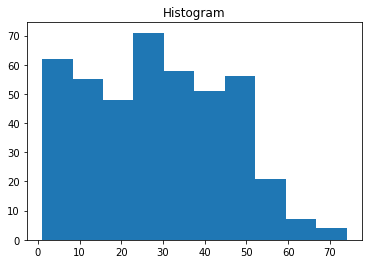

In [18]:
dst_filename = '/Users/miksch/Thesis_Files/Processed/landsat/NLCD2011_MODIS.tif'
dst = xr.open_rasterio(dst_filename).sel(band=2)
dst = dst.where(dst > 0.)
dst.plot.hist()

In [12]:
print(dst.min())

<xarray.DataArray ()>
array(17.)
Coordinates:
    band     int64 2


(array([  9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 178.]),
 array([17. , 23.4, 29.8, 36.2, 42.6, 49. , 55.4, 61.8, 68.2, 74.6, 81. ],
       dtype=float32),
 <a list of 10 Patch objects>)

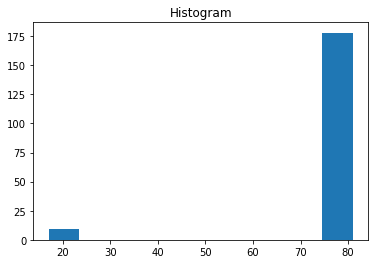

In [8]:
dst_filename = '/Users/miksch/Thesis_Files/Processed/MODIS/lst/2016_06_01.tif'
dst = xr.open_rasterio(dst_filename).sel(band=2)
dst = dst.where(dst > 0.)
dst.plot.hist()


(array([32588., 36341., 36878., 34610., 35143., 36207., 27199., 16227.,
        13612., 17396.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <a list of 10 Patch objects>)

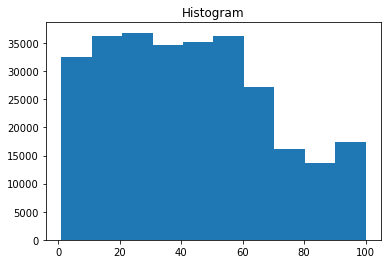

In [115]:
dst_filename = '/Users/miksch/Thesis_Files/Processed/landsat/NLCD2011.tif'
dst = xr.open_rasterio(dst_filename).sel(band=2)
dst = dst.where(dst > 0.)
dst.plot.hist()

In [ ]:


sharp = data_dict['ls8_sharp'].sel(time='2018-09-11')
nosharp = data_dict['ls8_nosharp'].sel(time='2018-09-11')*.1

def offset_error(orig_data, offset_data, offset_dict, var1='B10', var2='energy_conserved'):
    '''
    Function to determine the mean RMSD between the two grids
    '''
    
    #Shift data based on offset_dict
    for d in offset_dict:
        offset_data = offset_data.assign_coords(**{d:offset_data[d]+offset_dict[d]})
    
    merge_data = xr.merge([orig_data,offset_data])
    
    err = np.nanmean(np.square(merge_data[var1].values - merge_data[var2].values))

    return err

of = 15
offsets = {'+,+':[of,of],
           '+,-':[of,-of],
           '-,+':[-of,of],
           '-,-':[-of,-of]
          }


for o in offsets:
    offset_dict = {'x':offsets[o][0],
                   'y':offsets[o][1]
    }

    error = offset_error(nosharp['B10'],sharp['energy_conserved'],offset_dict)
    
    print(f'{o}: {error}')